# Optical Characterization with Machine Learning

Explanation

## 1) Libraries

Explanation

In [1]:
# Basic libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Autoreload the code
%load_ext autoreload
%autoreload 2

In [3]:
# We import the functions from our package
from src.models import * 
from src.generating import * 

import src.ML_data as data
import src.ML_routine as routine
import src.general as general

## 2) Generating multiple spectra

Explanation

In [4]:
# Wavelength range
wv = torch.arange(800, 2100, 4) 

# Ideal transmission of a transparent substrate
Ts = torch.ones(len(wv))*0.92

# Models for refractive index n and extinction coefficient k 
model_n = 'Wemple-DiDomenico'
model_k = 'Urbach'

In [5]:
# Generating dataset - initializing the class
generate = generating(wavelength = wv, T_substrate = Ts, \
    model_n = model_n, model_k = model_k)

# Input: 1D transmission spectrum, output: its 1D envelope 
input_orig, output_orig = generate.spectra(n_samples = 10000)

# Adding one channel for the input and output
input = input_orig[:, None, :]
output = output_orig[:, None, :]


output/input_output.png


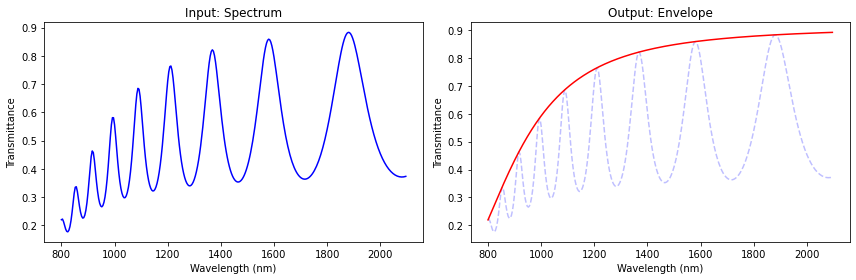

In [6]:
# Visualizing one spectrum
general.visualize(wv = wv, input = input_orig, output = output_orig, sample = 0)
general.save_fig_as_png('input_output')

## 3) Learning the envelopes with CNN

### (a) Dataset

In [10]:
train_loader, validation_loader, test_loader = \
    data.prepare_datasets(input = input, output = output, batch_size = 100)


--- Print from training dataset (batches) ---
conv1D takes (batches, channels = 1, features)
The input transmission of size = torch.Size([100, 1, 325])
The output envelope of size = torch.Size([100, 1, 325])


### (b) Training the model

In [56]:
model = routine.training(train_loader, validation_loader, learning_rate = 0.0001, num_epochs = 400)

Epoch [40/400]
Training loss: 0.00096, validation loss: 0.00089
Epoch [80/400]
Training loss: 0.00021, validation loss: 0.00021
Epoch [120/400]
Training loss: 0.00013, validation loss: 0.00013
Epoch [160/400]
Training loss: 0.00008, validation loss: 0.00010
Epoch [200/400]
Training loss: 0.00007, validation loss: 0.00007
Epoch [240/400]
Training loss: 0.00007, validation loss: 0.00007
Epoch [280/400]
Training loss: 0.00004, validation loss: 0.00005
Epoch [320/400]
Training loss: 0.00005, validation loss: 0.00004
Epoch [360/400]
Training loss: 0.00004, validation loss: 0.00003
Epoch [400/400]
Training loss: 0.00003, validation loss: 0.00003


### (c) Evaluating the model

Accuracy of the network on the test spectra: 95.00708770751953 %


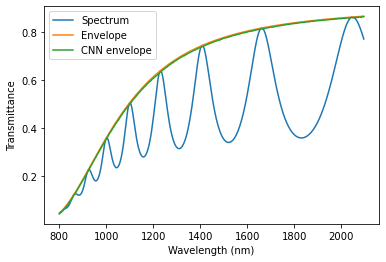

In [59]:
routine.testing(wv, test_loader, model, prediction_sample = 0)

## 4) Calculating envelopes of real spectra

### 4.1. Loading the real spectrum

output/real_spectra_14.png


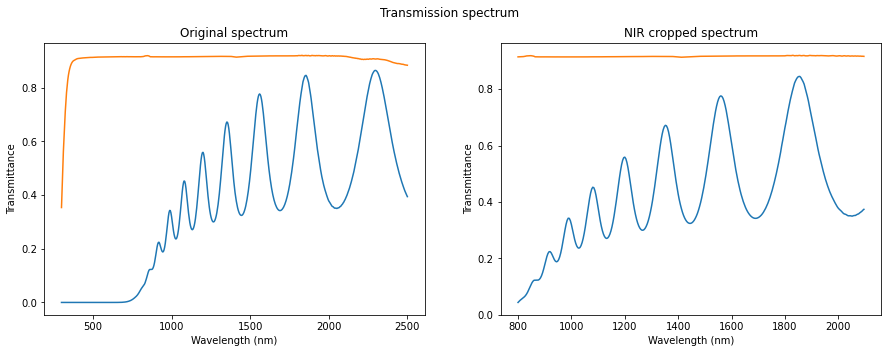

In [60]:
# Sample
sample = 14             # For the 'real' spectra, there are 1 to 14 samples
type_sample = 'real'    # Either 'real' or 'simulated' spectra  

name_Sample = 'spectrum_'+str(sample)
name_Substrate= 'Substrate_'+str(sample)


# Wavelength (wv), sample transmission (T), and transmission of the substrate alone (Ts)
wv, T, Ts = general.load_spectra(type_sample = type_sample, name_Sample = name_Sample, \
    name_Substrate = name_Substrate)

figtitle = 'real_spectra_' + str(sample)
general.save_fig_as_png(figtitle)

### 4.2. Applying our model

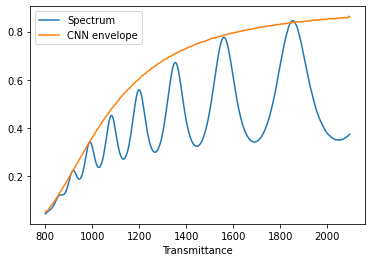

In [61]:
# Prepering the sample
examples = iter(test_loader)
X, y = examples.next()
X[0,0,:] = T[:]

# Applying the model
y_predicted = model(X).detach()

# Visualize and save the result
figtitle = 'output/real_envelope_' + str(sample) + '.png'

plt.plot(wv, T, label = 'Spectrum')
plt.plot(wv, y_predicted[0,0,:], label = 'CNN envelope')
plt.xlabel('Wavelength (nm)')
plt.xlabel('Transmittance')
plt.ylim(0,1)
plt.legend()
plt.savefig(figtitle, dpi = 300)
plt.show()

### 4.3 Analyzing substrates

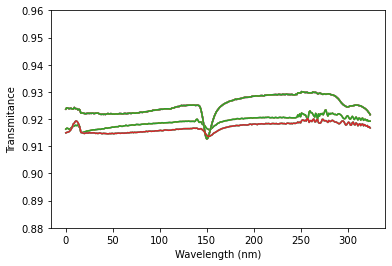

In [55]:
for i in range(1, 15):
    
    # Empty strings
    name_Sample =''
    name_Substrate = ''

    # Our samples
    name_Sample = 'spectrum_'+str(i)
    name_Substrate = 'Substrate_'+str(i)

    # File names
    file_Substrate = 'data/Real_samples/'+ name_Substrate + '.txt'
    file_Sample = 'data/Real_samples/'+ name_Sample + '.txt'

    # Download data
    data = np.loadtxt(file_Sample)             # Sample data
    wv_original = np.round(np.flip(data[:,0])) # Wavelength (in nm)
    T_original = np.flip(data[:,1])/100        # Sample transmittance (range 0-1)

    data_s = np.loadtxt(file_Substrate)        # Substrate alone data
    Ts_original = np.flip(data_s[:,1])/100     # Substrate transmittance (range 0-1)
    
    # From original data to the cropped spectrum (800-2100 nm only)
    wv, T, Ts = general.cropped_spectrum(wv_original, T_original, Ts_original)
    
    # Plot transmission of the substrate alone
    plt.plot(Ts)

plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmitance')
plt.ylim(0.88,0.96)
plt.savefig('output/substrates_analysis.png', dpi = 300)
plt.show()